In [1]:
from Bio import SeqIO
from Bio.Seq import Seq
import pandas as pds
import matplotlib as mpl
import seaborn as sbn
import matplotlib.pyplot as plt
import gzip
from mdutils.mdutils import MdUtils as mdu
from mdutils import Html

In [2]:
mpl.use('Agg')

In [2]:
#CODE TO CALCULATE LIMITS FOR GC COUNT TO SELECT DATA

GC_dict = {} #creation of a void dictionary to store GC count

#opening of gzip file of assembly and GC count of the different scaffolds
with open("/mnt/md0/Tick/raw_data/Rsan/GCA_013339695.2_BIME_Rsan_1.4_genomic.fna", "rt") as handle:
    for seq_record in SeqIO.parse(handle, "fasta"):
        count = 100*float(seq_record.seq.count("G")+seq_record.seq.count("C")+seq_record.seq.count("g")+seq_record.seq.count("c"))/(len(seq_record.seq)-(seq_record.seq.count("N")+seq_record.seq.count("n")))
        GC_dict[seq_record.id] = count

#transformation of the dictionary to a pandas DataFrame
GC_items = GC_dict.items()

GC_list = list(GC_items)

GC_df = pds.DataFrame (GC_list)

#renaming of DataFrame columns
GC_df.columns = ["ID", "Count"]

#calculating limits for the GC count for later use
sup = GC_df.Count.quantile(0.95)
inf = GC_df.Count.quantile(0.05)


In [3]:
sup

49.87049633526702

In [4]:
inf

44.4473012403324

In [5]:
#CODE TO CALCULATE LIMITS FOR DEPTH COVERAGE SELECTION
#BUSCO GENES DEFINE HOMOZYGOUS PEAK

#opening and readin .csv file with depth coverage for genes
genes_op = open ("/mnt/md0/Tick/raw_data/Rsan/coverage/CRR142594_mapping_depthgenes.coverage.csv")
genes_cover = pds.read_csv (genes_op)

In [6]:
#creating void list
buscor = []

#opening and reading file with busco genes names and inserting them in list
busco = open("/mnt/md0/Tick/raw_data/Rsan/complete_busco.list")
buscor = [i.rstrip() for i in busco.readlines ()]

In [7]:
#selecting genes with a cover inferior to 200
genes_cover1 = genes_cover[genes_cover["0"]<200]

#selecting busco genes
busco_cover = genes_cover1[genes_cover1["ID_gene"].isin(buscor)]

In [8]:
busco_cover.median(numeric_only=True).iloc[0]

9.452747252747251

In [9]:
#calculating median to locate the homozygous peak
busco_median = busco_cover.median(numeric_only=True)

#extracting median number from DataFrame
bmed = busco_median.iloc[0]

#calculating upper and lower limit based on homo- and heterozygous peaks
superior_busco = bmed * 1.35
inferior_busco = (bmed / 2)*0.65

In [10]:
#CODE TO SELECT SCAFFOLDS I AM INTERESTED IN

#creating void dictionary to store GC count values
GC_dictionary = {}

#opening fasta file containing scaffolds sequences and calculating GC count for them, storing values in dictionary
scaf_seq = SeqIO.parse (open("/mnt/md0/Tick/raw_data/Rsan/spades_assembly/CRR142594/CRR142594_scaffolds.fasta"), 'fasta')
for seq_records in scaf_seq:
    count = 100*float(seq_records.seq.count("G")+seq_records.seq.count("C"))/(len(seq_records.seq)-seq_records.seq.count("N"))
    GC_dictionary[seq_records.id] = count

In [11]:
len(GC_dictionary)

203725

In [12]:
#opening coverage .csv file and storing it in a DataFrame
cov_csv = open("/mnt/md0/Tick/raw_data/Rsan/spades_assembly/CRR142594/CRR142594_coverage_tab.csv")
cov_read = pds.read_csv(cov_csv)

In [13]:
cov_read

,#rname,startpos,endpos,numreads,covbases,coverage,meandepth,meanbaseq,meanmapq
0,NODE_1_length_610963_cov_7.964403,1,610963,69884,610963,100.0000,17.0996,255,59.9
1,NODE_2_length_596753_cov_15.258541,1,596753,132073,596655,99.9836,33.0853,255,59.9
2,NODE_3_length_568855_cov_7.737546,1,568855,63244,568855,100.0000,16.6218,255,59.9
3,NODE_4_length_481740_cov_17.212744,1,481740,120021,481643,99.9799,37.2477,255,59.8
4,NODE_5_length_478261_cov_7.521738,1,478261,51544,478261,100.0000,16.1461,255,60.0
...,...,...,...,...,...,...,...,...,...
203720,NODE_203719_length_78_cov_33.000000,1,78,0,0,0.0000,0.0000,0,0.0
203721,NODE_203720_length_78_cov_29.000000,1,78,0,0,0.0000,0.0000,0,0.0
203722,NODE_203721_length_78_cov_26.000000,1,78,0,0,0.0000,0.0000,0,0.0
203723,NODE_203723_length_78_cov_6.000000,1,78,0,0,0.0000,0.0000,0,0.0


In [14]:
#creating a smaller DataFrame containing just the values I am interested in
sub_cov_df = cov_read[["#rname","endpos","meandepth"]]

In [15]:
#adding a new column to the DataFrame containing GC counts, pairing the values based on the scaffold ID
sub_cov_df["GC_count"] = sub_cov_df["#rname"].apply(lambda x : GC_dictionary[x])

#renaming the columns
sub_cov_df.columns= ["Name", "Length", "Depth", "Count"]

/tmp/ipykernel_268717/1928883773.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_cov_df["GC_count"] = sub_cov_df["#rname"].apply(lambda x : GC_dictionary[x])


In [16]:
#selection of the scaffolds based on length
smaller_len = sub_cov_df[sub_cov_df.Length > 1000]

#selection of the scaffolds based on depth of coverage
inflim = smaller_len[smaller_len.Depth > inferior_busco]
smaller_len_cov = inflim[inflim.Depth < superior_busco]

#selection of the scaffolds based on GC count
inf_count = smaller_len_cov[smaller_len_cov.Count > inf]
final_scaffolds_list = inf_count[inf_count.Count < sup]


In [17]:
#creates file to store fasta sequences
fi = open("/mnt/md0/Tick/raw_data/Rsan/spades_assembly/CRR142594/CRR142594_selected.fasta", "a")

#writes IDs from DataFrame to a list
ID_list = final_scaffolds_list["Name"].values.tolist()

In [18]:
#controls if sequences ID is in the ID list from the DataFrame and if so it writes the sequence into the new file
all_sc = open("/mnt/md0/Tick/raw_data/Rsan/pangenome.fasta", "a")
scaf_seq = SeqIO.parse (open("/mnt/md0/Tick/raw_data/Rsan/spades_assembly/CRR142594/CRR142594_scaffolds.fasta"), 'fasta')
for sequences in scaf_seq:
    if sequences.id in ID_list:
        r = SeqIO.write(sequences, fi, "fasta")
        p = SeqIO.write(sequences, all_sc, "fasta")

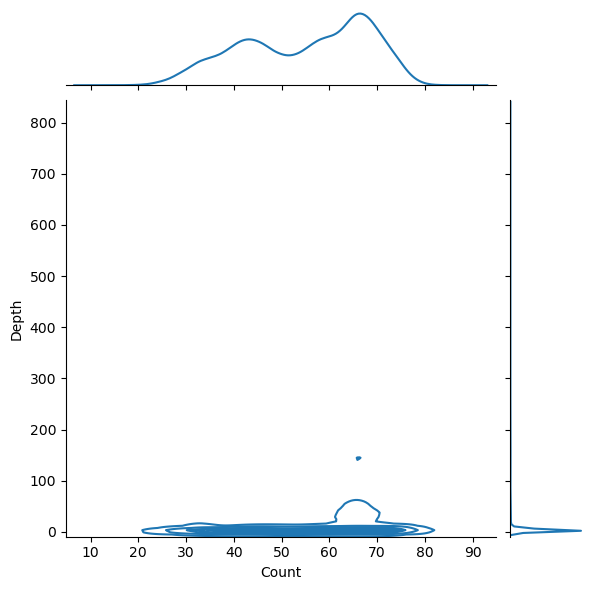

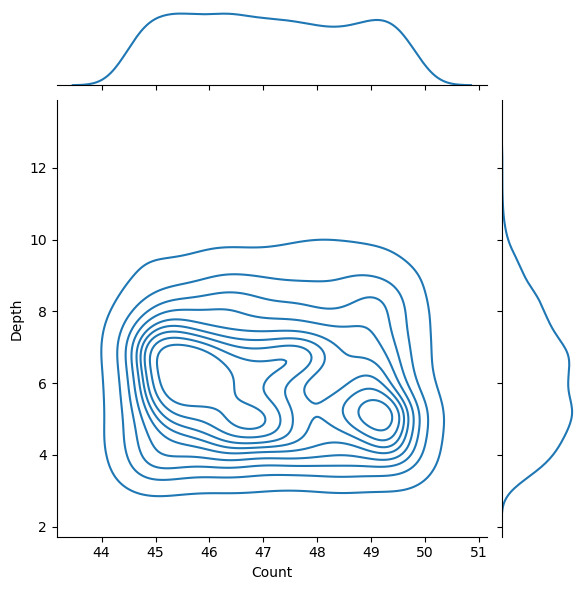

In [19]:
#creates plot from not-selected DataFrame
grafico = sbn.jointplot(data=sub_cov_df, x=sub_cov_df.Count, y=sub_cov_df.Depth, kind="kde")
#creates plot from selected DataFrame
grafico1 = sbn.jointplot(data=final_scaffolds_list, x=final_scaffolds_list.Count, y=final_scaffolds_list.Depth, kind="kde")

#saves both plots into different .svg files
grafico.savefig("/mnt/md0/Tick/raw_data/Rsan/spades_assembly/CRR142594/CRR142594_kde_plot_not_selected.svg", format="svg")
grafico1.savefig("/mnt/md0/Tick/raw_data/Rsan/spades_assembly/CRR142594/CRR142594_kde_plot_selected.svg", format="svg")

In [20]:
final_scaffolds_list["Length"].sum()

4268918

In [21]:
max(final_scaffolds_list["Length"])

9868

In [22]:
min(final_scaffolds_list["Length"])

1001

In [23]:
supe = str(round(superior_busco, 2))
infe = str (round(inferior_busco, 2))

In [24]:
# Writes the report for each individual based on the data previously calculated and analyzed
# For the first individual it should be done manually
report = mdu(file_name = "/mnt/md0/Tick/raw_data/Rsan/spades_assembly/CRR142594/report_CRR142594.md", title =  "CRR142594 Individual Report")
report.new_header(level = 1, title = " ")
report.new_header(level = 2, title = "1. Number of unmapped reads extracted from the mapping of the individual's reads on the reference genome:")
report.new_line("    ")
report.new_line("17007006")
report.write(" reads.")
report.new_paragraph()
report.new_header(level = 2, title = "2. Number of scaffolds assembled by SPAdes assembly program, with associated graph:")
report.new_line("    ")
report.new_line("203725")
report.write(" scaffolds.")
report.new_line(report.new_inline_image(text = "", path = "/mnt/md0/Tick/raw_data/Rsan/spades_assembly/CRR142594/CRR142594_kde_plot_not_selected.svg"))
report.new_paragraph()
report.new_header(level = 2, title = "3. Parameters for scaffold selection:")
report.new_line("    ")
report.new_line("Scaffolds length: 1000 bp.\n")
report.new_line("    ")
report.new_line("Coverage: based on the coverage value found for Busco genes from the reference genome. Limits considered are 135% of homozygous peak and 65% of hemizygous peak.")
report.new_line("        ")
report.write("  - Upper limit = ")
report.write(supe)
report.new_line("        ")
report.write("  - Lower limit = ")
report.write(infe)
report.write("\n")

# WARNING!! 
# Edit this line with your second assembly, from which you calculate GC count. 
# Remember to also modify the upper and lower limit values.
report.new_line("GC count: based on GC count from " + report.new_inline_link(link = "https://www.ncbi.nlm.nih.gov/assembly/GCA_013339695.2", text = "BIME_Rsan_1.4"))
report.write(" assembly from NCBI database. Considered 90th percentile as valid.")
report.new_line("        ")
report.write(" - Upper limit = 49.87") # CHANGE THIS
report.new_line("        ")
report.write(" - Lower limit = 44.45") # CHANGE THIS
report.new_paragraph()
report.new_header(level = 2, title = "4. Number of scaffolds after selection through parameters, with associated graph:")
report.new_line("    ")
report.new_line("2364")
report.write(" scaffolds. The number of megabases for the selected scaffolds are: ")
report.write("4.268918")
report.write(".")
report.new_line(report.new_inline_image(text = "", path = "/mnt/md0/Tick/raw_data/Rsan/spades_assembly/CRR142594/CRR142594_kde_plot_selected.svg"))
report.create_md_file()